Universidade Federal do Rio Grande do Sul (UFRGS)   
Programa de Pós-Graduação em Engenharia Civil (PPGEC)   

# PEC00025: Introduction to Vibration Theory


## Test P2 (2021/1): multiple d.o.f. and continuous systems

---

**NAME:** <br/>
**CARD:** 


#### Instruções

1. Entregar a resolução da prova em arquivo único, com no máximo 10Mb, até às 12h de amanhã, 01 de junho de 2021.
2. Recomenda-se verificar atentamente se todas as folhas da resolução foram incluídas no arquivo gerado, pois não serão aceitas entregas posteriores.
3. Na primeira folha do arquivo deve constar claramente o NOME e o cartão de MATRÍCULA.
4. A consulta ao material de estudo e o uso do computador para cálculos são LIVRES.
5. A prova deve ser realizada INDIVIDUALMENTE, sem recorrer ao auxílio de colegas ou outras pessoas! Caso se verifique o descumprimento desta regra, todos os envolvidos na fraude terão a nota da prova zerada.


In [1]:
# Importing Python modules required for this notebook
# (this cell must be executed with "shift+enter" before any other Python cell)

import numpy as np
import scipy.linalg as sc
import matplotlib.pyplot as plt

from MRPy import *


## Questão 1

<img src="resources/tests/PEC00025A_211_P2_Q1.jpg" alt="Question 1" width="640px"/>


Dados do problema:

In [2]:
H  =  3.             # altura de cada pavimento (m)
M  =  10000.         # massa de cada pavimento (kg)
f1 =  1.             # frequência fundamental (Hz)
zt =  0.01           # amortecimento modal (adim., mesma nos dois modos)
g  =  9.81           # aceleração da gravidade (m/s^2)


Função para cálculo dos modos de vibração:

In [3]:
def vibration_modes(K, M):

# 1. Uses scipy to solve the standard eigenvalue problem
    w2, Phi = sc.eig(K, M)

# 2. Ensure ascending order of eigenvalues
    iw  = w2.argsort()
    w2  = w2[iw]
    Phi = Phi[:,iw]

# 3. Eigenvalues to vibration frequencies
    wk  = np.sqrt(np.real(w2)) 
    fk  = wk/2/np.pi

# 4. Mass matrix normalization
    Mk = np.diag(np.dot(Phi.T, np.dot(M, Phi)))
    
    for k in range(len(wk)):
        Phi[:,k] = Phi[:,k]/np.sqrt(Mk[k])
            
# 5. Return results
    return fk, wk, Phi


Monta matrizes e calcula modos:

In [4]:
K  =  1.00                               # rigidez de cada coluna (incógnita)

KG =  K*np.array([[2, -2], [-2, 4]])     # rigidez global
MG =  M*np.array([[1,  0], [ 0, 1]])     # massa global

fk, wk, Phi = vibration_modes(KG, MG)

K  = (f1/fk[0])**2                       # determina a rigidez correta
fk =  fk*np.sqrt(K)                      # calcula todas as frequências
wk =  fk*2*np.pi                         # em rad/s

print('Rigidez individual de cada barra: {0:6.1f}kN/m.'.format(K/1000))
print('Frequência no primeiro modo:      {0:6.2f}Hz.'.format(fk[0]))
print('Frequência no segundo modo:       {0:6.2f}Hz.'.format(fk[1]))

#print(wk)

Rigidez individual de cada barra:  516.8kN/m.
Frequência no primeiro modo:        1.00Hz.
Frequência no segundo modo:         2.62Hz.


Visualiza modos:

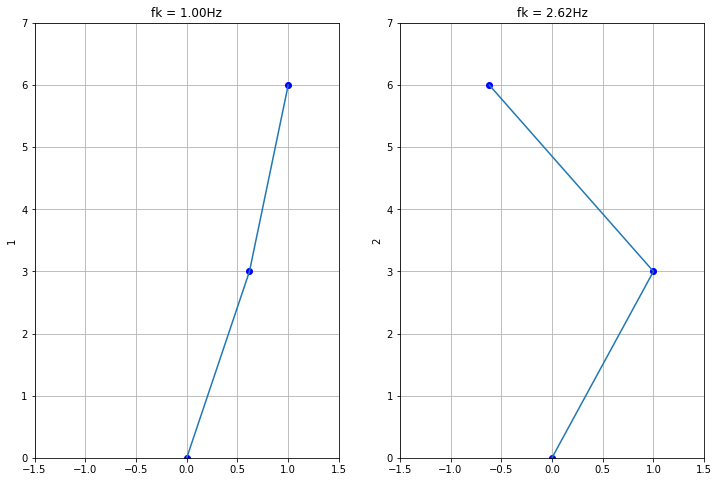

In [5]:
plt.figure(1, figsize=(12,8))

x = H*np.arange(3)

for k in range(2):
    qk = np.zeros(3)
    qk[1:] = Phi[::-1,k]
    qk /= np.max(np.abs(qk))   # adjust scale for unity amplitude
    
    plt.subplot(1,2,k+1)
    plt.plot(qk, x, 'bo')
    plt.plot(qk, x)
    
    plt.xlim(-1.5, 1.5);  plt.ylabel(str(k+1));
    plt.ylim( 0.0, 7.0);
    plt.title('fk = {0:4.2f}Hz'.format(fk[k]));
    plt.grid(True)


## Questão 2

<img src="resources/tests/PEC00025A_211_P2_Q2.jpg" alt="Question 2" width="640px"/>


A excitação tem mesma amplitude nas frequências de 0.5 e 3Hz. Para usar as amplificações dinâmicas, vamos admitir que o pico das respostas modais poderão estar em fase.

In [6]:
FG  =  0.1*g*np.diag(MG).reshape(2,1)                     # amplitude das forças nos pavimentos
Fk  =  np.matmul(Phi.T, FG)                               # amplitude das forças modais

Mk  =  np.diag(np.dot(Phi.T, np.dot(MG, Phi)))            # massas modais
Kk  =  wk*wk*Mk                                           # rigidezes modais
uk  =  np.empty(2)                                        # aloca memória para respostas modais

for k, fn in enumerate(fk):
    
    bt    = [0.5, 3.0]/fn                                 # frequências componentes da excitação
    AD    =  np.sqrt(1/((1 - bt**2)**2 + (2*zt*bt)**2))   # respectivas amplificações dinâmicas
    uk[k] = (Fk[k]/Kk[k])*np.sum(AD)                      # pico da resposta modal amplificada
    
u = np.matmul(Phi,uk)

print('Máximo deslocamento no pavimento superior: {0:6.4f}m.'.format(u[0]))


Máximo deslocamento no pavimento superior: 0.0398m.


O mesmo cálculo agora por simulação, integrando por Fourier através do módulo ``MRPy``:

In [7]:
Td  =  32.
N   =  1024

t   =  np.linspace(0, Td, N)                              # domínio do tempo
F   =  FG*(np.sin(np.pi*t) + np.sin(6*np.pi*t))           # força dinâmica


Calcula forças modais e resolve equações de equilíbrio desacopladas:

Máximo deslocamento no pavimento superior: 0.0388m.


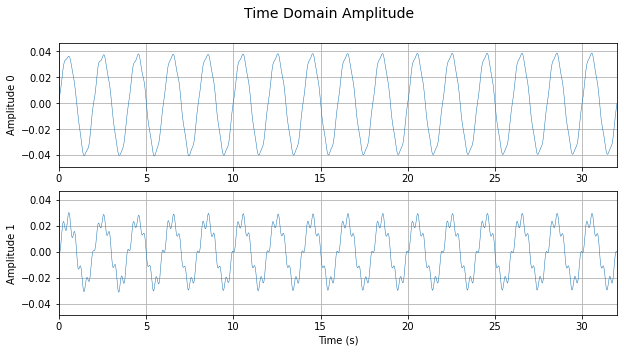

In [8]:
Fk =  MRPy(np.matmul(Phi.T, F), Td=Td)                    # cria objeto MRPy

for k in range(2):
    Fk[k,:] /= Mk[k]                                      # prepara para solução

uk =  Fk.sdof_Fourier(fk, zt)                             # calcula respostas modais
u  =  np.matmul(Phi,uk)                                   # deslocamento nos pavimentos

print('Máximo deslocamento no pavimento superior: {0:6.4f}m.'.format(u[0,:].max()))

u.plot_time(1, figsize=(10,5));


A diferença dos dois resultados se deve a que o pico das respostas modais não está perfeitamente em fase. 
Portanto a solução numérica, que é a mais precisa, apresenta amplitude ligeiramente menor.


## Questão 3

<img src="resources/tests/PEC00025A_211_P2_Q3.jpg" alt="Question 3" width="640px"/>


Primeiro vamos calcular a resposta exata, aplicando as condições de contorno na solução geral:

$$ \varphi(x) = C_1 \left(\cos px + \cosh px \right) + 
                C_2 \left(\cos px - \cosh px \right) + 
                C_3 \left(\sin px + \sinh px \right) + 
                C_4 \left(\sin px - \sinh px \right) $$  

onde:

$$ p^4 = \left(\frac{\mu}{EI}\right) \omega^2 $$

As condições de contorno são:

\begin{align*}
 \varphi(0)                      &= 0 \\
 \varphi^{\prime\prime}(0)       &= 0 \\
 \varphi^{\prime}(L)             &= 0 \\
 \varphi^{\prime\prime\prime}(L) &= 0
\end{align*}

Aplicando essas condições na solução geral temos, para $x = 0$:

\begin{align*}
\varphi(0)                &=  C_1 \left( 1 + 1 \right) + 
                              C_2 \left( 1 - 1 \right) + 
                              C_3 \left( 0 + 0 \right) + 
                              C_4 \left( 0 - 0 \right) = 0 \\
\varphi^{\prime\prime}(0) &=  C_1 \left(-1 + 1 \right) + 
                              C_2 \left(-1 - 1 \right) + 
                              C_3 \left(-0 + 0 \right) + 
                              C_4 \left(-0 - 0 \right) = 0
\end{align*}

Portanto $C_1 = 0$ e $C_2 = 0$. Por outro lado, para $x = L$:
                              
\begin{align*}                              
\varphi^\prime(L)               &= C_3 \left( \cos pL + \cosh pL \right) + 
                                   C_4 \left( \cos pL - \cosh pL \right) = 0 \\
\varphi^{\prime\prime\prime}(L) &= C_3 \left(-\cos pL + \cosh pL \right) + 
                                   C_4 \left(-\cos pL - \cosh pL \right) = 0
\end{align*}

Colocando as equações acima em forma matricial temos:

$$ \left[ \begin{array}{cc}
                 \left( \cos pL + \cosh pL \right) & \left( \cos pL - \cosh pL \right) \\
                 \left(-\cos pL + \cosh pL \right) & \left(-\cos pL - \cosh pL \right) 
          \end{array} \right] 
 \left[ \begin{array}{c}
                  C_3 \\
                  C_4 
        \end{array} \right]  =                
 \left[ \begin{array}{c}
                  0 \\
                  0 
        \end{array} \right] $$

Fazendo o determinante da matrix de coeficientes igual a zero temos as frequência naturais.
Estas frequências podem ser calculadas numericamente, como mostrado abaixo.


In [9]:
def char_eq(x):
    
    x = x[0]
    A = np.array([[ np.cos(x)+np.cosh(x),  np.cos(x)-np.cosh(x)], 
                  [-np.cos(x)+np.cosh(x), -np.cos(x)-np.cosh(x)]])
 
    return np.linalg.det(A)

#-----------------------------------------------------------------------

from scipy.optimize import fsolve

p = fsolve(char_eq, 1.0)

print('Cantilever beam frequency parameter is {0:8.6f}...'.format(p[0]))


Cantilever beam frequency parameter is 1.570796...


Ou seja, o parâmetro de frequência parece ser $\pi/2$ e a frequência fundamental resulta:

$$ \omega_1 = \left(\frac{\pi}{2L} \right)^2 \sqrt{\frac{EI}{\mu}} $$

que coerentemente corresponde à frequência fundamental de uma viga bi-apoiada com vão $2L$. 
Isso está correto já que a condição de apoio da direita equivale a uma condição de simetria para uma viga com o 
dobro do vão!

Agora vamos refazer o cálculo propondo a seguinte função aproximada para a forma modal:

$$ \varphi(x) = \frac{1}{L^2}\left( 2Lx - x^2 \right) $$

ou seja, uma parábola que apresenta derivada nula para $x = L$, e portanto respeita _algumas_ condições de contorno. A escala desta forma modal é intencionalmente escolhida como sendo unitária. As derivadas dessa forma modal aproximada são:

\begin{align*}
 \varphi^{\prime}(x)       &=  (2L - 2x)\,/L^2 \\
 \varphi^{\prime\prime}(x) &=  -2\,/L^2
\end{align*}

Observa-se que a função proposta não cumpre a condição de momento nulo na extremidade da esquerda, mas vamos em frente.
A correspondente energia cinética de referência é:

$$ T_{\rm ref} = \frac{1}{2} \int_0^L {\mu \varphi ^2(x) \, dx} 
               = \frac{4}{15} \, \mu L   $$

enquanto a energia potencial elástica resulta:

$$ V = \frac{1}{2} \int_0^L {EI \left[ \varphi^{\prime\prime}(x) \right] ^2 \, dx}
     = \frac{2EI}{L^3}  $$

Portanto o quociente de Rayleigh resulta:

$$ \omega_1 = \sqrt{\frac{V}{T_{\rm ref}}}
            = \sqrt{\frac{2EI \cdot 15}{4\mu L^4}} 
            = \left(\frac{120^{1/4}}{2L} \right)^2 \sqrt{\frac{EI}{\mu}} $$

onde $120^{1/4} \approx 3.31$ e portanto esse valor apresenta um erro de aproximadamente 5.4%, esperado em relação ao valor correto, $\pi$, e um erro de aproximadamente 11% em relação à 
frequência correta. 
Observe que o quociente de Rayleigh sempre fornece frequência igual ou maior que a exata.


## Questão 4

<img src="resources/tests/PEC00025A_211_P2_Q4.jpg" alt="Question 4" width="640px"/>


Dados do problema:

In [10]:
L  =  6.             # comprimento da viga (m)
m  =  80.            # massa da pessoa (kg)
mu =  200.           # massa por unidade de comprimento (kg/m)
EI =  36.e6          # rigidez à flexão (Nm^2)


Vamos considerar a resposta apenas no primeiro modo. A dissipação de energia por amortecimento
é desprezada e a energia total do sistema deve se manter constante e igual à a energia potencial 
gravitacional da pessoa no início da queda:

$$ E = mgh = 784.8{\rm J}$$

Por questão de simplicidade, admite-se que a viga já está deformada por peso próprio quando se 
determina a altura de queda da pessoa. Também vamos considerar que o choque é perfeitamente inelástico, 
ou seja, a viga e a pessoa seguem unidos após o contato.

Observe que forma modal proposta é normalizada pela unidade, de modo que ela tem valor unitário na 
extremidade da direita, $\varphi(L) = 1$. 
Desta forma, deslocamento vertical e deslocamento modal tem mesmo valor numérico
no ponto B.

A energia cinética total do sistema após o choque é calculada como:

$$ T = \frac{1}{2} \int_0^L {\mu \left[ v_0 \varphi(x) \right]^2 \, dx}
     + \frac{1}{2} m\left[ v_0 \varphi(L) \right] ^2  = 360v_0^2$$

onde $v_0$ é a velocidade inicial da extremidade direita da viga logo após o choque, que é numericamente
igual à velocidade inicial no espaço modal. Igualando-se as energias, $E = T$, chega-se a:

$$ v_0 = \sqrt{\frac{784.8}{360}} \approx 1.48{\rm m/s}$$


A frequência natural no primeiro modo precisa ser re-calculada, pois agora a viga tem também a massa
da pessoa incorporada na extremidade direita. A nova energia cinética de referência é:

$$ T_{\rm ref} = \frac{1}{2} \int_0^L {\mu \varphi^2(x) \, dx} + \frac{1}{2} m \varphi^2(L)  = 360 $$

A energia potencial elástica, $V$, permanece a mesma e, portanto, a frequência natural resulta menor:

$$ \omega_{\rm n} = \sqrt{\frac{V}{T_{\rm ref}}}
                  = \sqrt{\frac{2\cdot 36\times 10^6}{360 \cdot 6^3}} \approx 30.42{\rm rad/s} $$

Sem a massa da pessoa incorporada, a frequência natural calculada na seção anterior seria de $32.27{\rm rad/s}$.

A amplitude total do delocamento modal é a soma da amplitude devida à velocidade inicial 
com o deslocamento  devido à carga impulsiva. 
Dada a escala unitária da forma modal, a força modal tem o mesmo módulo da força aplicada na 
extremidade da direita.
O formato retangular da carga impulsiva (choque inelástico) implica que o fator de amplificação dinâmica, 
$A$, da resposta estática, $u_{B, \rm est}$, é igual a 2. 

$$ u_{B, \rm max} = \frac{v_0}{\omega_{\rm n}} + A \, u_{B, \rm est} $$

Para calcular a resposta estática é necessário conhecer a massa modal:

$$ M = \int_0^L {\mu \varphi^2(x) \, dx} + m \varphi^2(L) = 720{\rm kg}$$

Lembrando que a rigidez modal é dada por $K = \omega^2_{\rm n} M$, a resposta estática é calculada como:

$$ u_{B, \rm est} = \frac{mg \varphi(L)}{K} = \frac{80 \cdot 9.81 \cdot 1}{30.42^2 \cdot 720} \approx 1.18{\rm mm}$$ 

Substituindo valores:

$$ u_{B, \rm max} = \frac{1.48}{30.42} + 2 \cdot 0.00118 \approx  5.1{\rm cm}$$
